# Weighted Mean Analysis

To prove a point

In [1]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap, collation_tools as ct
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest
from astropy.table import vstack

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

master_hvcs = hvcl.load_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24])

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete
=== HVC RM LOADER ===
Taking HVC snapshots
Process complete


In [2]:
def get_stacked_sets(snapshots):
    inners = []
    outers = []
    for hvc_snap in snapshots:
        inner_rms, outer_rms = KStest.split_RMs(hvc_snap["RMs"],hvc_snap["HVC"]["SkyCoord"], KStest.morph_ring(hvc_snap))
        inners.append(inner_rms)
        outers.append(outer_rms)

    master_rm_inner = vstack(inners)
    master_rm_outer = vstack(outers)

    return master_rm_inner, master_rm_outer, inners, outers

master_rm_inner, master_rm_outer, inners, outers = get_stacked_sets(master_hvcs)

In [3]:
import numpy as np
from astropy.table import Table

def weighted_average_individual(data, uncs):
    weights = 1 / (uncs * 1e6)**2

    return np.average(data, weights=weights), 1/np.sum(weights)

def weighted_average(inners, outers):
    avg_in = []
    unc_in = []
    avg_ot = []
    unc_ot = []
    for i in range(len(inners)):
        av, un = weighted_average_individual(inners[i]["B_virtual [int]"], inners[i]["B_virtual_unc [int]"])
        avg_in.append(av)
        unc_in.append(un)
        av, un = weighted_average_individual(outers[i]["B_virtual [int]"], outers[i]["B_virtual_unc [int]"])
        avg_ot.append(av)
        unc_ot.append(un)
    
    avg_diff = np.array(avg_in) - np.array(avg_ot)
    unc_diff = np.sqrt(np.array(unc_in) ** 2 + np.array(unc_ot) ** 2)

    t = Table()
    t["Average [inner]"] = np.array(avg_in) * 1e6
    t["Average [outer]"] = np.array(avg_ot) * 1e6
    t["Average [diff]"] = avg_diff * 1e6
    t["Avg Unc [inner]"] = np.array(unc_in)
    t["Avg Unc [outer]"] = np.array(unc_ot)
    t["Avg Unc [diff]"] = unc_diff

    return t

wavgs = weighted_average(inners, outers)
wavgs

Average [inner],Average [outer],Average [diff],Avg Unc [inner],Avg Unc [outer],Avg Unc [diff]
float64,float64,float64,float64,float64,float64
-1.3506194176296213,-2.560210571743284,1.2095911541136628,0.007003852876365774,0.0032940466469477043,0.007739812557552317
-0.056445222198439816,-1.1991611171284744,1.1427158949300344,0.010148842996047043,0.0006398107274504492,0.010168990703377291
1.500776660653911,0.052073639648805965,1.448703021005105,0.007129552203987939,0.002050088534124988,0.007418448464951416
-2.0433500968670546,-0.7515102964160036,-1.291839800451051,0.18157752049511933,0.007404423938031661,0.18172842772392428
-0.3570725165898588,-1.1535705764067303,0.7964980598168715,0.042906373222247746,0.007109176796687973,0.0434913469303192
-0.7672410917916938,-0.7426862708275596,-0.024554820964134253,0.04655645277823943,0.01318809477546906,0.04838831614242422
-3.620108937244275,-7.837450117500442,4.217341180256167,0.4686915287204748,0.13939402347543306,0.4889810250664184
4.0206400164297795,0.17353602031256268,3.8471039961172173,0.11708586076209412,0.0424759648413749,0.12455242422211704
0.8210758855823943,2.499888949334954,-1.67881306375256,0.16176219741916012,0.013152603813846201,0.1622960242919072


In [4]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap, collation_tools as ct
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest, uncertainty_subtraction as us

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs_filtered"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

#master_hvcs = hvcl.manual_filter_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24])

#results = hvcl.uncertainty_subtract_HVCs(collated_data, filter_significant=False, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24])#, save_file="", filter_significant=False)

results = ct.read_processed("../data_processed/results_pre")
results_filtered = us.filter_significant(results)

#collated_data['HVCs']
results

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete


Name,Statistic,p_value,Statistic_x,Statistic_sgn,Statistic_diff,Significant,Sigma [meas],Sigma [obsv],Sigma [true],Sigma [diff],FWHM
str15,float64,float64,float64,int32,float64,bool,float64,float64,float64,float64,float64
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-3.515687526708854,-1,2.5503785393572116,True,1.5490103064419392,3.259633374868092,2.8680615072014404,-1.2004037875138898,-2.82673490096878
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-0.6963302660734451,-1,1.245611675868496,True,1.0172162310775188,2.2736826533710723,2.033446322742001,-0.3820916381721009,-0.8997570486063758
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-1.2589038059025925,-1,2.2846397376409495,True,1.3692498776485982,3.4139391636197307,3.1273207998949974,-0.3219533860094135,-0.7581422869405536
G089.0-64.7-311,0.3738140417457306,0.015075834341180974,-3.5031459148744912,1,-2.4420848538134305,False,1.7766805216998156,6.285240753776755,6.028901861595415,4.354124583319416,10.253179847362592
G133.5-75.6-294,0.46130268199233715,4.570648166268751e-08,-1.0081759072724916,-1,1.7746068755102902,True,1.390653120203451,0.6443423969361269,nan,nan,nan
G248.9+36.8+181,0.08070447918650822,0.452664079053446,-2.5040967925547646,-1,0.5189262304682574,False,2.5577313774843344,3.3456971641453612,2.1567799412092095,-0.4370240961740395,-1.0291131018321615
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-5.487954609053061,-1,7.064597943499491,True,8.363070544185819,12.507923833010205,9.300925205879048,5.8850039182248,13.858125191721438
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,2.0255699650566523,-1,5.008552948039634,True,5.0791565705667105,9.744382180123484,8.315957708164293,-11.277167064796421,-26.555699055345446
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,0.9062634882158793,1,-2.1167595348071426,True,3.023390368905306,4.983729795251348,3.9619027435421326,0.16014564072012671,0.377114164892079


In [5]:
from astropy.table import hstack

bigger_results = hstack([results, wavgs])
big_results_filtered = us.filter_significant(bigger_results)


In [6]:
ct.write_processed(big_results_filtered, "../data_processed/results_weighted")

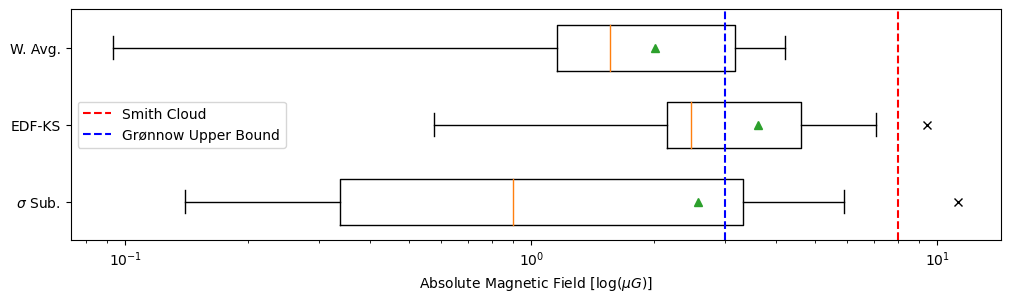

In [7]:
import matplotlib.pyplot as plt

dic = {r"$\sigma$ Sub.": abs(big_results_filtered["Sigma [diff]"]), "EDF-KS": abs(big_results_filtered["Statistic_diff"]), "W. Avg.": abs(big_results_filtered["Average [diff]"])}
plt.figure(figsize=(12,3))
plt.boxplot(dic.values(), labels=dic.keys(), vert=False, showmeans=True, widths=0.6, sym="x")
plt.axvline(8, c='r', linestyle='--', label=r"Smith Cloud")
plt.axvline(3, c='b', linestyle='--', label=r"Grønnow Upper Bound")
plt.xlabel(r"Absolute Magnetic Field [log($\mu G$)]")
plt.xscale('log')
#plt.xlim(0.1, 15)
plt.legend()
plt.show()

In [8]:
from scipy.stats import linregress

results_stack = us.filter_significant(hstack([bigger_results, collated_data['HVCs']]))

Var. Sub. slope: -17.805664205141778
KS-EDF slope:    -34.84456795228249
Wgt. Avg. slope: -26.102591078715918
Var. Sub. x-int: 2.230997544596407
KS-EDF x-int:    2.15066290491125
Wgt. Avg. x-int: 1.8360607295844216
Var. Sub. R^2:   0.5186636363538069
KS-EDF R^2:      0.5714890256256061
Wgt. Avg. R^2:   0.6329942540354568


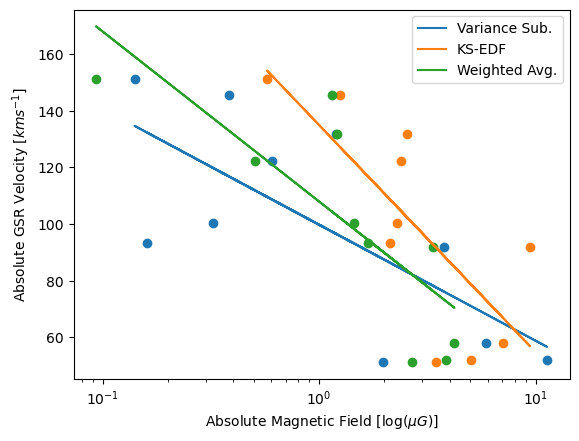

In [9]:
plt.scatter(abs(results_stack["Sigma [diff]"]), abs(results_stack['VGSR']))
plt.scatter(abs(results_stack["Statistic_diff"]), abs(results_stack['VGSR']))
plt.scatter(abs(results_stack["Average [diff]"]), abs(results_stack['VGSR']))

plt.xscale('log')
#plt.xlim(0.1, 15)

pf10, pf11, r_value1, p_value1, std_err1 = linregress(np.log(abs(results_stack["Sigma [diff]"])), abs(results_stack['VGSR']))
pf20, pf21, r_value2, p_value2, std_err2 = linregress(np.log(abs(results_stack["Statistic_diff"])), abs(results_stack['VGSR']))
pf30, pf31, r_value3, p_value3, std_err3 = linregress(np.log(abs(results_stack["Average [diff]"])), abs(results_stack['VGSR']))

plt.plot(abs(results_stack["Sigma [diff]"]), pf10 * np.log(abs(results_stack["Sigma [diff]"])) + pf11, label="Variance Sub.")
plt.plot(abs(results_stack["Statistic_diff"]), pf20 * np.log(abs(results_stack["Statistic_diff"])) + pf21, label="KS-EDF")
plt.plot(abs(results_stack["Average [diff]"]), pf30 * np.log(abs(results_stack["Average [diff]"])) + pf31, label="Weighted Avg.")

plt.xlabel(r"Absolute Magnetic Field [log($\mu G$)]")
plt.ylabel(r"Absolute GSR Velocity [$km s^{-1}$]")
plt.legend()

print(r"Var. Sub. slope: "+str(pf10))
print(r"KS-EDF slope:    "+str(pf20))
print(r"Wgt. Avg. slope: "+str(pf30))

#print(r"Var. Sub. y-int: "+str(pf11))
#print(r"KS-EDF y-int:    "+str(pf21))

print(r"Var. Sub. x-int: "+str((60-pf11)/pf10))
print(r"KS-EDF x-int:    "+str((60-pf21)/pf20))
print(r"Wgt. Avg. x-int: "+str((60-pf31)/pf30))

print(r"Var. Sub. R^2:   "+str(r_value1**2))
print(r"KS-EDF R^2:      "+str(r_value2**2))
print(r"Wgt. Avg. R^2:   "+str(r_value3**2))

plt.show()

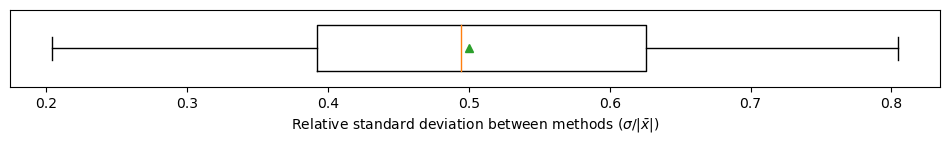

In [25]:
plt.figure(figsize=(12,1))

lists = [abs(big_results_filtered["Sigma [diff]"]), abs(big_results_filtered["Statistic_diff"]), abs(big_results_filtered["Average [diff]"])]

std = np.std(lists, axis=0)/np.mean(lists, axis=0)

plt.boxplot(std, vert=False, showmeans=True,widths=0.6, sym="x")
plt.yticks([])
#plt.axvline(8, c='r', linestyle='--', label=r"Smith Cloud")
plt.xlabel(r"Relative standard deviation between methods ($\sigma/|\bar{x}|$)")
#plt.xscale('log')
#plt.xlim(0.1, 15)
#plt.legend()
plt.show()